# Table of contents

* [Load dataset](#Load-dataset)

* [Sentence embeddings](#Sentence-embeddings)
    * [With several csv files](#With-several-csv-files)
* [Each csv as one point](#Each-csv-as-one-point)

# Load dataset

In [9]:
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import decomposition
%matplotlib inline

In [4]:
data_folder = "held_in_csv/"

In [7]:
labels_df = pd.read_csv(data_folder + "Y_held_in.csv")
labels_df.head()

,SMID,Diagnosis2,Score
0,101378,Negative,0
1,103694,Positive,2
2,106002,Negative,0
3,107667,Negative,0
4,107776,Negative,0


## Number of positive vs negative

In [6]:
labels_df.Diagnosis2.value_counts()

Negative    514
Positive    156
Name: Diagnosis2, dtype: int64

## Distribution of scores

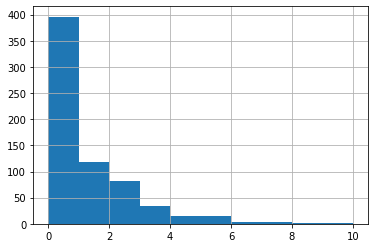

In [10]:
labels_df.Score.hist()

In [11]:
labels_df.SMID # can be used to load given files

0      101378
1      103694
2      106002
3      107667
4      107776
        ...  
665    986952
666    988738
667    990890
668    991587
669    993861
Name: SMID, Length: 670, dtype: int64

# Sentence embeddings

Sentence embedding using BERT
[ref](https://github.com/UKPLab/sentence-transformers)

Install package with ` pip install -U sentence-transformers `

Download pretrained model

In [2]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

## Example using one csv file

In [66]:
sentences_df = pd.read_csv(data_folder + str(labels_df.SMID[0])+".csv")
sentences_df.head()

,SMID,TimeStamp,Message,Type,StillParticipant,Participants,ConvoKey,PhotoPath,Direction,Removed,Sender
0,101378,1555380623698,Messenger sent an attachment.,Share,True,"Messenger, Murt Jatoi",archived_threads/Messenger_D4ueVKGrUQ,NaN,Incoming,False,Messenger
1,101378,1555380623620,Say ð to the new Messenger! We've simplifie...,Generic,True,"Messenger, Murt Jatoi",archived_threads/Messenger_D4ueVKGrUQ,NaN,Incoming,False,Messenger
2,101378,1561483301653,You left the group.,Unsubscribe,False,"Saad Asif Dagra, Thomas Montana, Jack Bittman,...",archived_threads/theKollective_Vkau5Vzfbw,NaN,Outgoing,False,Murt Jatoi
3,101378,1561407440491,Abageal Phelan left the group.,Unsubscribe,False,"Saad Asif Dagra, Thomas Montana, Jack Bittman,...",archived_threads/theKollective_Vkau5Vzfbw,NaN,Incoming,False,Abageal Phelan
4,101378,1561315719422,Yahvi Mahendra left the group.,Unsubscribe,False,"Saad Asif Dagra, Thomas Montana, Jack Bittman,...",archived_threads/theKollective_Vkau5Vzfbw,NaN,Incoming,False,Yahvi Mahendra


### Transfer sentences into embeddings with pretrained model
Input: list of sentences, each entry is one sentence
Output: list of embeddings, each entry vector of dim 768 **(idk why 768?)**

somehow fast (30s for 554 sentences)

In [71]:
%%time
sentences= sentences_df.Message.astype("str").to_list()
sentence_embeddings = model.encode(sentences)
len(sentences_df)

CPU times: user 30.3 s, sys: 555 ms, total: 30.8 s
Wall time: 15.7 s


554

### Visualize embeddings in one csv file
Not very useful but just use as an example

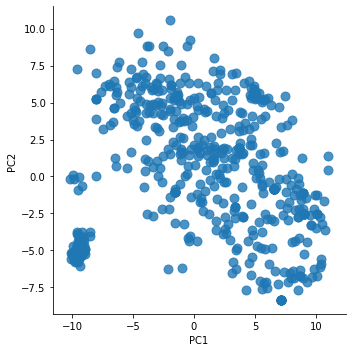

In [74]:
pca = decomposition.PCA(n_components=4)
pc = pca.fit_transform(sentence_embeddings)
pc_df = pd.DataFrame(data = pc , 
        columns = ['PC1', 'PC2','PC3','PC4'])
sns.lmplot( x="PC1", y="PC2", data=pc_df, fit_reg=False, scatter_kws={"s": 80})

## With several csv files

In [40]:
embeddings_df = pd.DataFrame(columns=['SMID', 'TimeStamp', 'Message', 'Type', 'StillParticipant',
       'Participants', 'ConvoKey', 'PhotoPath', 'Direction', 'Removed',
       'Sender', 'Embeddings', 'Score', 'Label'])

In [44]:
sentences_df = pd.read_csv(data_folder + str(labels_df.SMID[1])+".csv")

In [41]:
# this can be really slow if you have too many files, there are around 10k sentences in i=1, takes around 5-10min
for i in range(2):
    sentences_df = pd.read_csv(data_folder + str(labels_df.SMID[i])+".csv")
    sentences= sentences_df.Message.astype("str").to_list()
    sentence_embeddings = model.encode(sentences)
    sentences_df["Embeddings"] = sentence_embeddings
    sentences_df["Score"] = labels_df["Score"][i]
    sentences_df["Label"] = labels_df["Diagnosis2"][i]
    embeddings_df = embeddings_df.append(sentences_df)

In [51]:
pca = decomposition.PCA(n_components=4)
pc = pca.fit_transform(embeddings_df.Embeddings.to_list())
pc_df = pd.DataFrame(data = pc , 
        columns = ['PC1', 'PC2','PC3','PC4'])
pc_df["Score"] = embeddings_df.Score.to_list()
pc_df["Label"] = embeddings_df.Label.to_list()

You can plot the explained variance ratio if you want to

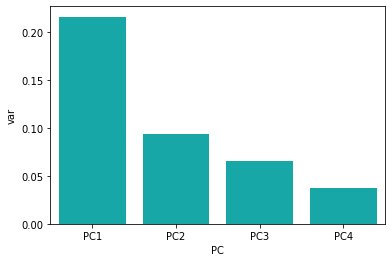

In [52]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3','PC4']})
sns.barplot(x='PC',y="var", 
           data=df, color="c")

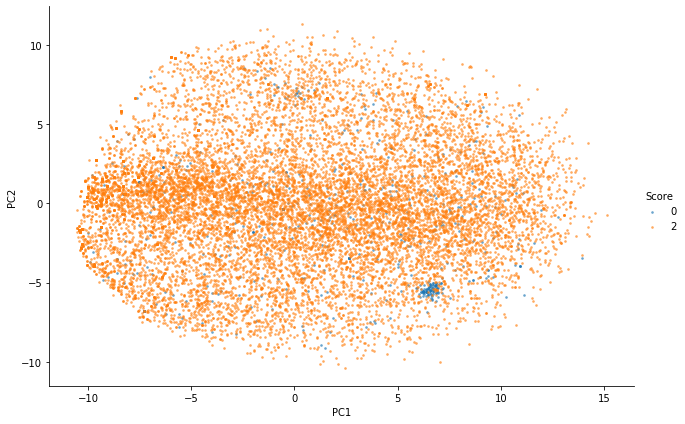

In [65]:
sns.lmplot( x="PC1", y="PC2",
  data=pc_df, 
  fit_reg=False, 
  hue='Score', # color by score, can be changed to label, SMID(?)...
  legend=True,
  scatter_kws={"s": 3, "alpha": 0.5},
   height=6,
  aspect = 1.5) # specify the point size

# Each csv as one point

We can certainly try to extract features from embeddings, one plan is to use Gaussian distribution to approximate every csv, as (center, variance).

Also there must be some overlapping part, (new friend, NA, ...), we can also "denoise" the embeddings or remove PC1, or ...?